In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [3]:
df = pd.read_csv("/content/Creditcard_data.csv")

fraud = df[df["Class"] == 1]
non_fraud = df[df["Class"] == 0]

non_fraud_sample = non_fraud.sample(len(fraud), random_state=42)
balanced_df = pd.concat([fraud, non_fraud_sample]).sample(frac=1, random_state=42)

X = balanced_df.drop("Class", axis=1)
y = balanced_df["Class"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Sampling

In [4]:
def simple_random_sampling(X, y):
    return train_test_split(X, y, test_size=0.3, random_state=42)

def stratified_sampling(X, y):
    return train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

def systematic_sampling(X, y):
    step = 3
    indices = np.arange(0, len(X), step)
    X_sys = X[indices]
    y_sys = y.iloc[indices]
    return train_test_split(X_sys, y_sys, test_size=0.3, random_state=42)

def cluster_sampling(X, y):
    balanced_df["Cluster"] = balanced_df["Amount"].apply(lambda x: 0 if x < 50 else 1)
    cluster_0 = balanced_df[balanced_df["Cluster"] == 0]
    sample_cluster = cluster_0.sample(frac=0.5, random_state=42)

    X_c = sample_cluster.drop(["Class", "Cluster"], axis=1)
    y_c = sample_cluster["Class"]
    return train_test_split(X_c, y_c, test_size=0.3, random_state=42)

def cross_validation_sampling(X, y):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, test_index in skf.split(X, y):
        return X[train_index], X[test_index], y.iloc[train_index], y.iloc[test_index]

sampling_methods = {
    "Simple Random Sampling": simple_random_sampling,
    "Stratified Sampling": stratified_sampling,
    "Systematic Sampling": systematic_sampling,
    "Cluster Sampling": cluster_sampling,
    "Cross Validation Sampling": cross_validation_sampling
}

In [5]:
models = {
    "M1_LogisticRegression": LogisticRegression(max_iter=1000),
    "M2_DecisionTree": DecisionTreeClassifier(),
    "M3_RandomForest": RandomForestClassifier(n_estimators=100),
    "M4_SVM": SVC(),
    "M5_NaiveBayes": GaussianNB()
}

results = []

for s_name, s_func in sampling_methods.items():
    X_train, X_test, y_train, y_test = s_func(X_scaled, y)

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        results.append({
            "Sampling Technique": s_name,
            "Model": model_name,
            "Accuracy": acc
        })


In [7]:
results_df = pd.DataFrame(results)

results_df.to_csv("sampling_results.csv", index=False)
sampling_map = {
    "Simple Random Sampling": "Sampling1",
    "Stratified Sampling": "Sampling2",
    "Systematic Sampling": "Sampling3",
    "Cluster Sampling": "Sampling4",
    "Cross Validation Sampling": "Sampling5"
}
results_df["Sampling"] = results_df["Sampling Technique"].map(sampling_map)

table = results_df.pivot(
    index="Model",
    columns="Sampling",
    values="Accuracy"
)

print("\nAccuracy Comparision Table:\n")
print(table.round(2))

print("\nSAMPLING LEGEND:\n")
for full_name, short_name in sampling_map.items():
    print(f"{short_name}  →  {full_name}")



Accuracy Comparision Table:

Sampling               Sampling1  Sampling2  Sampling3  Sampling4  Sampling5
Model                                                                       
M1_LogisticRegression       0.33       0.17        0.0       0.33       0.50
M2_DecisionTree             0.67       0.83        0.5       0.33       0.75
M3_RandomForest             0.67       0.50        0.5       0.33       0.50
M4_SVM                      0.50       0.17        0.0       0.33       0.50
M5_NaiveBayes               0.50       0.67        0.5       0.33       0.25

SAMPLING LEGEND:

Sampling1  →  Simple Random Sampling
Sampling2  →  Stratified Sampling
Sampling3  →  Systematic Sampling
Sampling4  →  Cluster Sampling
Sampling5  →  Cross Validation Sampling


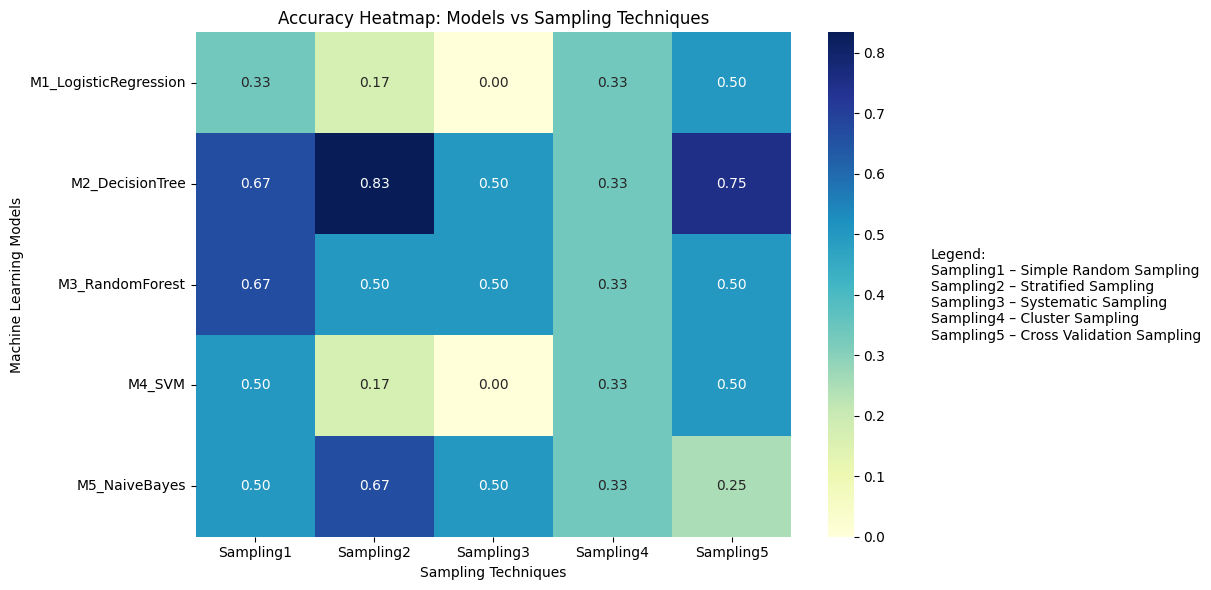

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

ax = sns.heatmap(
    table,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu"
)

plt.title("Accuracy Heatmap: Models vs Sampling Techniques")
plt.xlabel("Sampling Techniques")
plt.ylabel("Machine Learning Models")

legend_text = (
    "Legend:\n"
    "Sampling1 – Simple Random Sampling\n"
    "Sampling2 – Stratified Sampling\n"
    "Sampling3 – Systematic Sampling\n"
    "Sampling4 – Cluster Sampling\n"
    "Sampling5 – Cross Validation Sampling"
)

plt.gcf().text(
    0.78, 0.5, legend_text,
    fontsize=10,
    verticalalignment="center"
)

plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.show()
